In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import tensorflow as tf
import numpy as np
import pickle as pkl
from sklearn.manifold import TSNE

from flip_gradient import flip_gradient
from utils import *

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# Process MNIST
mnist_train = (mnist.train.images > 0).reshape(55000, 28, 28, 1).astype(np.uint8) * 255
mnist_train = np.concatenate([mnist_train, mnist_train, mnist_train], 3)
mnist_test = (mnist.test.images > 0).reshape(10000, 28, 28, 1).astype(np.uint8) * 255
mnist_test = np.concatenate([mnist_test, mnist_test, mnist_test], 3)

# Load MNIST-M
mnistm = pkl.load(open('mnistm_data.pkl', 'rb'))
mnistm_train = mnistm['train']
mnistm_test = mnistm['test']
mnistm_valid = mnistm['valid']

# Compute pixel mean for normalizing data
pixel_mean = np.vstack([mnist_train, mnistm_train]).mean((0, 1, 2))

# Create a mixed dataset for TSNE visualization
num_test = 500
combined_test_imgs = np.vstack([mnist_test[:num_test], mnistm_test[:num_test]])
combined_test_labels = np.vstack([mnist.test.labels[:num_test], mnist.test.labels[:num_test]])
combined_test_domain = np.vstack([np.tile([1., 0.], [num_test, 1]),
        np.tile([0., 1.], [num_test, 1])])


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


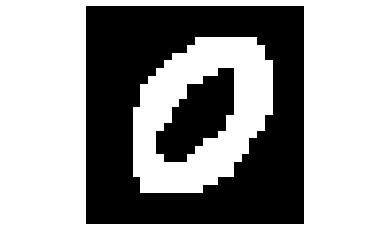

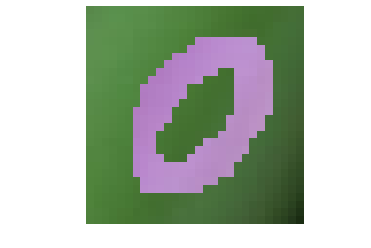

In [2]:
imshow_grid(mnist_train)
imshow_grid(mnistm_train)

In [3]:
batch_size = 64

class MNISTModel(object):
    """Simple MNIST domain adaptation model."""
    def __init__(self):
        self._build_model()
    
    def _build_model(self):
        
        self.X = tf.placeholder(tf.uint8, [None, 28, 28, 3])
        self.y = tf.placeholder(tf.float32, [None, 10])
        self.domain = tf.placeholder(tf.float32, [None, 2])
        self.l = tf.placeholder(tf.float32, [])
        self.train = tf.placeholder(tf.bool, [])
        
        X_input = (tf.cast(self.X, tf.float32) - pixel_mean) / 255.
        
        # CNN model for feature extraction
        with tf.variable_scope('feature_extractor'):

            W_conv0 = weight_variable([5, 5, 3, 32])
            b_conv0 = bias_variable([32])
            h_conv0 = tf.nn.relu(conv2d(X_input, W_conv0) + b_conv0)
            h_pool0 = max_pool_2x2(h_conv0)
            #print(h_pool0.get_shape)
            
            W_conv1 = weight_variable([5, 5, 32, 48])
            b_conv1 = bias_variable([48])
            h_conv1 = tf.nn.relu(conv2d(h_pool0, W_conv1) + b_conv1)
            h_pool1 = max_pool_2x2(h_conv1)
            
            # Save for the domaint-feature
            self.h_pool = h_pool1
            
            # The domain-invariant feature
            self.feature = tf.reshape(h_pool1, [-1, 7*7*48])
            
        # MLP for class prediction
        with tf.variable_scope('label_predictor'):
            
            # Switches to route target examples (second half of batch) differently
            # depending on train or test mode.
            all_features = lambda: self.feature
            source_features = lambda: tf.slice(self.feature, [0, 0], [batch_size // 2, -1])
            classify_feats = tf.cond(self.train, source_features, all_features)
            
            all_labels = lambda: self.y
            source_labels = lambda: tf.slice(self.y, [0, 0], [batch_size // 2, -1])
            self.classify_labels = tf.cond(self.train, source_labels, all_labels)
            
            W_fc0 = weight_variable([7 * 7 * 48, 100])
            b_fc0 = bias_variable([100])
            h_fc0 = tf.nn.relu(tf.matmul(classify_feats, W_fc0) + b_fc0)
            
            W_fc1 = weight_variable([100, 100])
            b_fc1 = bias_variable([100])
            h_fc1 = tf.nn.relu(tf.matmul(h_fc0, W_fc1) + b_fc1)
            
            W_fc2 = weight_variable([100, 10])
            b_fc2 = bias_variable([10])
            logits = tf.matmul(h_fc1, W_fc2) + b_fc2
            
            self.pred = tf.nn.softmax(logits)
            self.pred_loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=self.classify_labels)

        # Small MLP for domain prediction with adversarial loss
        with tf.variable_scope('domain_predictor'):
            
            feat = flip_gradient(self.h_pool, self.l)
            
            W_conv2 = weight_variable([2, 2, 48, 48])
            b_conv2 = bias_variable([48])
            h_conv2 = tf.nn.relu(conv2d(feat, W_conv2) + b_conv2)
            h_pool2 = max_pool_2x2(h_conv2)
                        
            # Flip the gradient when backpropagating through this operation
            #feat = flip_gradient(self.feature, self.l)
            
            le_feat = tf.reshape(h_pool2, [-1, 4*4*48])
            
            d_W_fc0 = weight_variable([4 * 4 * 48, 100])
            d_b_fc0 = bias_variable([100])
            d_h_fc0 = tf.nn.relu(tf.matmul(le_feat, d_W_fc0) + d_b_fc0)
            
            d_W_fc1 = weight_variable([100, 2])
            d_b_fc1 = bias_variable([2])
            d_logits = tf.matmul(d_h_fc0, d_W_fc1) + d_b_fc1
            
            self.domain_pred = tf.nn.softmax(d_logits)
            self.domain_loss = tf.nn.softmax_cross_entropy_with_logits(logits=d_logits, labels=self.domain)


In [4]:
# Build the model graph
graph = tf.get_default_graph()
with graph.as_default():
    model = MNISTModel()
    
    learning_rate = tf.placeholder(tf.float32, [])
    
    pred_loss = tf.reduce_mean(model.pred_loss)
    domain_loss = tf.reduce_mean(model.domain_loss)
    total_loss = pred_loss + domain_loss

    regular_train_op = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(pred_loss)
    dann_train_op = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(total_loss)
    
    # Evaluation
    correct_label_pred = tf.equal(tf.argmax(model.classify_labels, 1), tf.argmax(model.pred, 1))
    label_acc = tf.reduce_mean(tf.cast(correct_label_pred, tf.float32))
    correct_domain_pred = tf.equal(tf.argmax(model.domain, 1), tf.argmax(model.domain_pred, 1))
    domain_acc = tf.reduce_mean(tf.cast(correct_domain_pred, tf.float32))


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [5]:
def train_and_evaluate(training_mode, graph, model, num_steps=8600, verbose=False):
    """Helper to run the model with different training modes."""

    with tf.Session(graph=graph) as sess:
        tf.global_variables_initializer().run()

        # Batch generators
        gen_source_batch = batch_generator(
            [mnist_train, mnist.train.labels], batch_size // 2)
        gen_target_batch = batch_generator(
            [mnistm_train, mnist.train.labels], batch_size // 2)
        gen_source_only_batch = batch_generator(
            [mnist_train, mnist.train.labels], batch_size)
        gen_target_only_batch = batch_generator(
            [mnistm_train, mnist.train.labels], batch_size)

        domain_labels = np.vstack([np.tile([1., 0.], [batch_size // 2, 1]),
                                   np.tile([0., 1.], [batch_size // 2, 1])])

        # Training loop
        for i in range(num_steps):
            
            # Adaptation param and learning rate schedule as described in the paper
            p = float(i) / num_steps
            l = 2. / (1. + np.exp(-10. * p)) - 1
            lr = 0.01 / (1. + 10 * p)**0.75

            # Training step
            if training_mode == 'dann':

                X0, y0 = next(gen_source_batch)
                X1, y1 = next(gen_target_batch)
                X = np.vstack([X0, X1])
                y = np.vstack([y0, y1])

                _, batch_loss, dloss, ploss, d_acc, p_acc = sess.run(
                    [dann_train_op, total_loss, domain_loss, pred_loss, domain_acc, label_acc],
                    feed_dict={model.X: X, model.y: y, model.domain: domain_labels,
                               model.train: True, model.l: l, learning_rate: lr})

                if verbose and i % 100 == 0:
                    print('loss: {}  d_acc: {}  p_acc: {}  p: {}  l: {}  lr: {} i: {}'.format(
                            batch_loss, d_acc, p_acc, p, l, lr,i))

            elif training_mode == 'source':
                X, y = next(gen_source_only_batch)
                _, batch_loss = sess.run([regular_train_op, pred_loss],
                                     feed_dict={model.X: X, model.y: y, model.train: False,
                                                model.l: l, learning_rate: lr})

            elif training_mode == 'target':
                X, y = next(gen_target_only_batch)
                _, batch_loss = sess.run([regular_train_op, pred_loss],
                                     feed_dict={model.X: X, model.y: y, model.train: False,
                                                model.l: l, learning_rate: lr})

        # Compute final evaluation on test data
        source_acc = sess.run(label_acc,
                            feed_dict={model.X: mnist_test, model.y: mnist.test.labels,
                                       model.train: False})

        target_acc = sess.run(label_acc,
                            feed_dict={model.X: mnistm_test, model.y: mnist.test.labels,
                                       model.train: False})
        
        test_domain_acc = sess.run(domain_acc,
                            feed_dict={model.X: combined_test_imgs,
                                       model.domain: combined_test_domain, model.l: 1.0})
        
        test_emb = sess.run(model.feature, feed_dict={model.X: combined_test_imgs})
        
    return source_acc, target_acc, test_domain_acc, test_emb


train_it = 8600

print('\nSource only training')
source_acc, target_acc, _, source_only_emb = train_and_evaluate('source', graph, model, train_it)
print('Source (MNIST) accuracy:', source_acc)
print('Target (MNIST-M) accuracy:', target_acc)

print('\nDomain adaptation training')
source_acc, target_acc, d_acc, dann_emb = train_and_evaluate('dann', graph, model, train_it)
print('Source (MNIST) accuracy:', source_acc)
print('Target (MNIST-M) accuracy:', target_acc)
print('Domain accuracy:', d_acc)


Source only training
Source (MNIST) accuracy: 0.987
Target (MNIST-M) accuracy: 0.5473

Domain adaptation training
Source (MNIST) accuracy: 0.9666
Target (MNIST-M) accuracy: 0.6122
Domain accuracy: 0.763


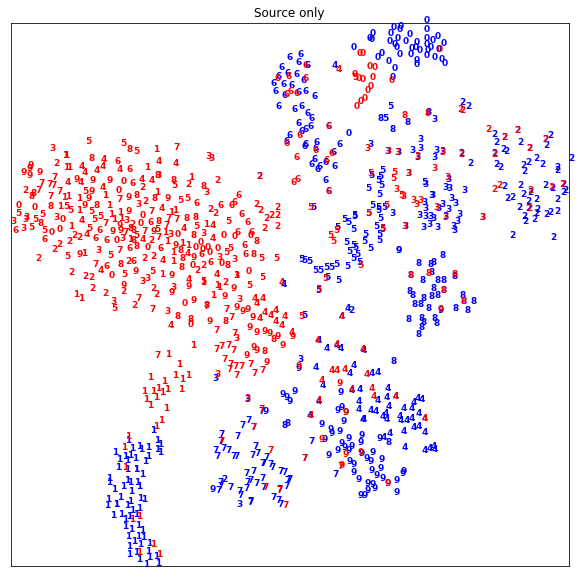

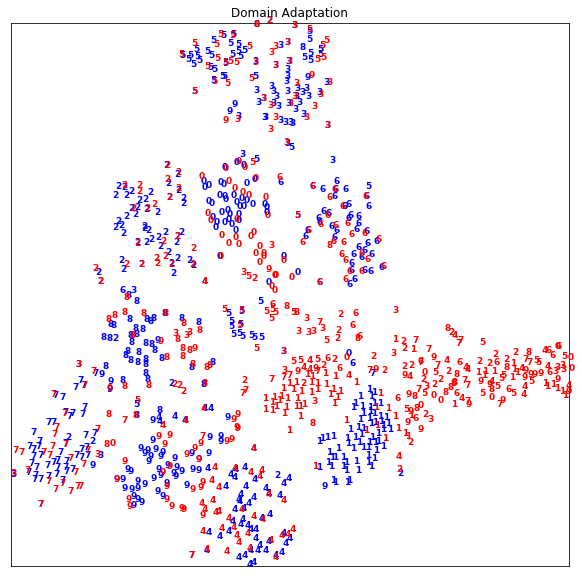

In [6]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
source_only_tsne = tsne.fit_transform(source_only_emb)

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
dann_tsne = tsne.fit_transform(dann_emb)
        
plot_embedding(source_only_tsne, combined_test_labels.argmax(1), combined_test_domain.argmax(1), 'Source only')
plot_embedding(dann_tsne, combined_test_labels.argmax(1), combined_test_domain.argmax(1), 'Domain Adaptation')